# Hardware Optimization of Quantum Violations of the CHSH Inquality

This script aggregates and plots data from CHSH optimizations on quantum hardware.

In [1]:
from context import QNetOptimizer as QNopt
import matplotlib.pyplot as plt
from pennylane import numpy as np

The data from all of our hardware optimizations is imported from file. 

In [2]:
from os import listdir
from os.path import isfile, join
import re

nat_grad_opt_dicts = []
param_shift_opt_dicts = []

data_path = "../../script/data/"

data_files = [join(data_path, f) for f in listdir(data_path) if isfile(join(data_path, f))]

for file in data_files:
    if bool(re.match(r".*simple_chsh_opt_ibm_belem_natural_gradient_.*\.json", file)):
        nat_grad_opt_dicts.append(QNopt.read_optimization_json(file))
    elif bool(re.match(r".*simple_chsh_opt_ibm_belem_parameter_shift_.*\.json", file)):
        param_shift_opt_dicts.append(QNopt.read_optimization_json(file))

We compute the mean and standard error across for each iteration across all hardware runs.

In [3]:
def scores_mean_stderr(opt_dicts):
    scores_array = np.array([opt_dict["scores"][0:15] for opt_dict in opt_dicts])    
    scores_mean = np.mean(scores_array, axis=0)   
    scores_stderr = np.std(scores_array, axis=0, ddof=1) / np.sqrt(scores_array.shape[1])

    return (scores_mean, scores_stderr)

## Natural Gradient Optimization

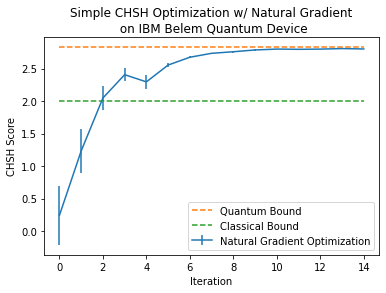

In [4]:
nat_grad_mean, nat_grad_err = scores_mean_stderr(nat_grad_opt_dicts)

plt.errorbar(range(15), nat_grad_mean, nat_grad_err, label="Natural Gradient Optimization")
plt.plot(range(15), [2*np.sqrt(2)]*15, "--", label="Quantum Bound")
plt.plot(range(15), [2]*15, "--", label="Classical Bound")
plt.title("Simple CHSH Optimization w/ Natural Gradient\n on IBM Belem Quantum Device")
plt.xlabel("Iteration")
plt.ylabel("CHSH Score")
plt.legend()
plt.show()

## Parameter Shift Optimization

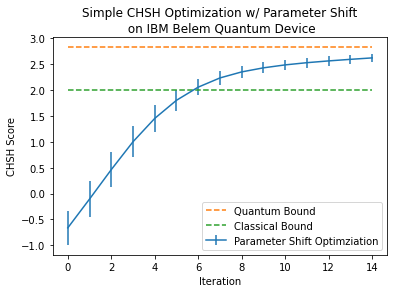

In [5]:
param_shift_mean, param_shift_err = scores_mean_stderr(param_shift_opt_dicts)

plt.errorbar(range(15), param_shift_mean, param_shift_err, label="Parameter Shift Optimziation")
plt.plot(range(15), [2*np.sqrt(2)]*15, "--", label="Quantum Bound")
plt.plot(range(15), [2]*15, "--", label="Classical Bound")
plt.title("Simple CHSH Optimization w/ Parameter Shift\n on IBM Belem Quantum Device")
plt.xlabel("Iteration")
plt.ylabel("CHSH Score")
plt.legend()
plt.show()